In [103]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys
import matplotlib.pyplot as plt

from fun_floodestimate import FloodHeight
from fun_floodestimate import FloodHeightWall
from fun_floodestimate import FloodTravelSectGroup
from fun_floodestimate import SurfaceVolFunc
from fun_damagecost import damage

from fun_objective_loop_manywalls import objective
#from fun_objective_loop_manywalls_GeoClaw impo

output_name = sys.argv[1]

#x = np.loadtxt(input_name)

#ws = int(sys.argv[1])
#we = int(sys.argv[2])
#wh = float(sys.argv[3])
#wall_year = int(sys.argv[4])
#fname = sys.argv[5]

# setup
# Surface Volume Input
ndiv18 = 18
sections = [10,11,5,12,1,13,16,4,17,15,3,14,0,9,8,7,2,6]
files = glob.glob('NewSurfaceVolumeCombined/LMN_div18_*.csv') 
groupcsvfiles = glob.glob('NewSurfaceVolumeGrouped/LMN_div18_*.csv') 
H = np.append(np.linspace(0,3,13),np.linspace(3.5,7,8))

SVfg1 = np.zeros([ndiv18,2]);  SVfg2 = np.zeros([ndiv18,2]);  SVfg3 = np.zeros([ndiv18,2]);  SVfg4 = np.zeros([ndiv18,2])
SVfg5 = np.zeros([ndiv18,2]);  SVfg6 = np.zeros([ndiv18,2]);  SVfg7 = np.zeros([ndiv18,2]);  SVfg8 = np.zeros([ndiv18,2])
SVfg9 = np.zeros([ndiv18,2]);  SVfg10 = np.zeros([ndiv18,2]); SVfg11 = np.zeros([ndiv18,2]); SVfg12 = np.zeros([ndiv18,2])
SVfg13 = np.zeros([ndiv18,2]); SVfg14 = np.zeros([ndiv18,2]); SVfg15 = np.zeros([ndiv18,2]); SVfg16 = np.zeros([ndiv18,2])
SVfg17 = np.zeros([ndiv18,2]); SVfg18 = np.zeros([ndiv18,2]); SVfg19 = np.zeros([ndiv18,2]); SVfg20= np.zeros([ndiv18,2])

i = 0
for f in groupcsvfiles:
    surfaceVg = pd.read_csv(f)["volume"]
    SVfg1[i,:],SVfg2[i,:],SVfg3[i,:],SVfg4[i,:],SVfg5[i,:],SVfg6[i,:],SVfg7[i,:],SVfg8[i,:],SVfg9[i,:],SVfg10[i,:],SVfg11[i,:],SVfg12[i,:],SVfg13[i,:],SVfg14[i,:],SVfg15[i,:],SVfg16[i,:],SVfg17[i,:],SVfg18[i,:],SVfg19[i,:],SVfg20[i,:] = SurfaceVolFunc(surfaceVg,H)
    i = i + 1 


SVf1 = np.zeros([ndiv18,2]);  SVf2 = np.zeros([ndiv18,2]);  SVf3 = np.zeros([ndiv18,2]);  SVf4 = np.zeros([ndiv18,2])
SVf5 = np.zeros([ndiv18,2]);  SVf6 = np.zeros([ndiv18,2]);  SVf7 = np.zeros([ndiv18,2]);  SVf8 = np.zeros([ndiv18,2])
SVf9 = np.zeros([ndiv18,2]);  SVf10 = np.zeros([ndiv18,2]); SVf11 = np.zeros([ndiv18,2]); SVf12 = np.zeros([ndiv18,2])
SVf13 = np.zeros([ndiv18,2]); SVf14 = np.zeros([ndiv18,2]); SVf15 = np.zeros([ndiv18,2]); SVf16 = np.zeros([ndiv18,2])
SVf17 = np.zeros([ndiv18,2]); SVf18 = np.zeros([ndiv18,2]); SVf19 = np.zeros([ndiv18,2]); SVf20= np.zeros([ndiv18,2])

SV_all = []
i = 0
for f in files:
    surfaceV_height = pd.read_csv(f)
    surfaceV = surfaceV_height["volume"]
    SV_all = np.append(SV_all,surfaceV)
    SVf1[i,:],SVf2[i,:],SVf3[i,:],SVf4[i,:],SVf5[i,:],SVf6[i,:],SVf7[i,:],SVf8[i,:],SVf9[i,:],SVf10[i,:],SVf11[i,:],SVf12[i,:],SVf13[i,:],SVf14[i,:],SVf15[i,:],SVf16[i,:],SVf17[i,:],SVf18[i,:],SVf19[i,:],SVf20[i,:] = SurfaceVolFunc(surfaceV,H)
    i = i+1
SV_all = SV_all.reshape(18,21)

roughness = pd.read_csv("Roughness.csv")["Roughness"]
slope = pd.read_csv("LMN_Slope.csv")["Slope"]

# Setup - Division Connectivities
sect3 = np.zeros([len(sections)-6,7])
k = 3
for i in sections[3:-3]:
    sect3[k-3] = [sections[k-3],sections[k-2],sections[k-1],i,sections[k+1],sections[k+2],sections[k+3]]
    k = k + 1

sect0  = [sections[0],sections[1],sections[2],sections[3]] 
sect1  = [sections[0],sections[1],sections[2],sections[3],sections[4]]
sect2  = [sections[0],sections[1],sections[2],sections[3],sections[4],sections[5]]

sect_3 = [sections[-6],sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_2 = [sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_1 = [sections[-4],sections[-3],sections[-2],sections[-1]]

# initial value
total_cost = 75*10**9 # total cost without any protective measure
cost_opt   = total_cost
x_opt 	   = [0,2040,0,0]

def objective2(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=100)
    print(total_cost_new)
    return total_cost_new

def objective3(x_input, numiter = 100):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = int(min(x_input[1],162))
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=numiter)
    return total_cost_new, wall_cost, n_cost_direct_sum_div

def objective3_test(x_input, numiter = 100):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = x_input[1]
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=numiter)
    return total_cost_new, wall_cost, n_cost_direct_sum_div

cons3 = [{'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 162-x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: 5.0-x[2]}]

def objective4(h, num_iter = 100):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=num_iter)
    print(total_cost_new)
    return total_cost_new, wall_cost, n_cost_direct_sum_div


C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
 

The GISSR method takes in a flood time history along the coast of lower Manhattan. The flood height along the coast varies with time but is specified beforehand as an input and is assumed to be constant along the length of the coast. GISSR then redistributes the water over the area of lower manhattan using ... and calculates the resulting damage cost. .... Below is a

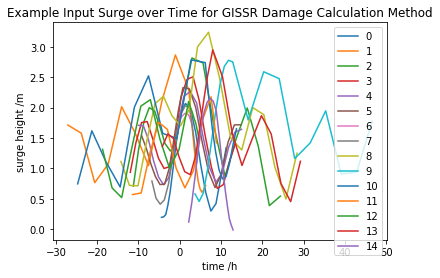

In [24]:
for i in range(15):
    surge_w_example = np.loadtxt('SurgeData/%d-waterlevel_w.csv'%i,skiprows = 1,delimiter = ',')
    times_w_example = np.loadtxt('SurgeData/%d-time_w.csv'%i,skiprows = 1, delimiter = ',')
    plt.plot(times_w_example[0,:],surge_w_example[0,:], label = str(i))
plt.xlabel('time /h')
plt.ylabel('surge height /m')
plt.title('Example Input Surge over Time for GISSR Damage Calculation Method')
plt.legend()
plt.show()


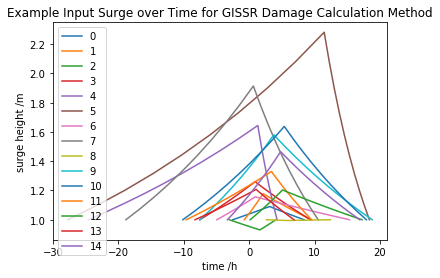

In [7]:
for i in range(15):
    surge_c_example = np.loadtxt('SurgeData/%d-surge_c.csv'%i,skiprows = 1,delimiter = ',')
    times_c_example = np.loadtxt('SurgeData/%d-time_c.csv'%i,skiprows = 1, delimiter = ',')
    plt.plot(times_c_example[0,:],surge_c_example[0,:], label = str(i))
plt.xlabel('time /h')
plt.ylabel('surge height /m')
plt.title('Example Input Surge over Time for GISSR Damage Calculation Method')
plt.legend()
plt.show()


When returning the total damage cost, there 

In [15]:
all_walls_array = np.load('all_walls_array.npy')
all_walls_div_array = np.load('all_walls_div_array.npy')
print(all_walls_array.shape)
print('start, end, height, total cost, wall cost')
print(all_walls_div_array.shape)

(1520, 5)
start, end, height, total cost, wall cost
(1520, 100, 18)


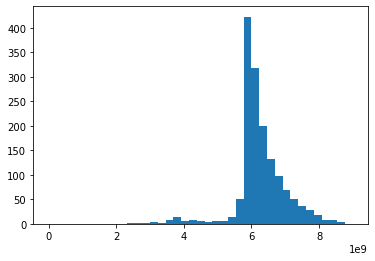

In [4]:
bins = np.linspace(0,9e9,40)
plt.hist(all_walls_array[:,3], bins = bins)
plt.show()

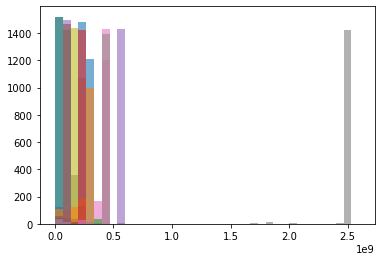

In [5]:
bins = np.linspace(0,2.6e9,40)
for i in range(18):
    plt.hist(np.mean(all_walls_div_array[:,:,i], axis = 1),alpha = 0.6, bins = bins)
    #plt.show()

# Histograms of damage cost for 100 simulations (80 year period of storms), by division 

Histograms of damage cost for 100 storms, by division
No wall:
damage cost 5.853187676374288
total cost  5.853187676374288
wall cost   0.0


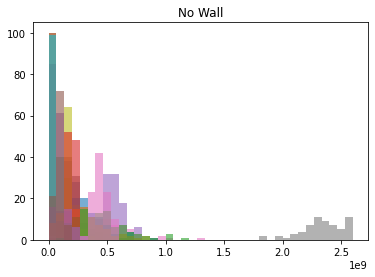

No budget optimal wall:
damage cost 0.45419682232838915
total cost  2.4472828223283893
wall cost   1.993086


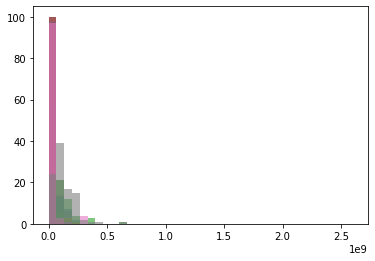

$1B budget optimal wall:
damage cost 5.809926745539627
total cost  6.683439745539627
wall cost   0.873513


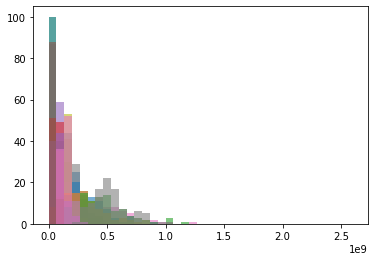

8 part different heights optimal wall:
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
damage cost 1.3349606189067706
total cost  2.3200208196121426
wall cost   0.9850602007053718


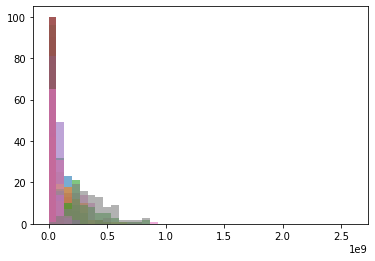

In [11]:
print('Histograms of damage cost for 100 storms, by division')

print('No wall:')
index = 0
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))
      
bins = np.linspace(0,2.6e9,40)
for i in range(18):
    plt.hist(all_walls_div_array[index,:,i],alpha = 0.6, bins = bins)
plt.ylabel = 'frequency'
plt.xlabel = 'damage cost /$'
plt.title('No Wall')
plt.show()

print('No budget optimal wall:')
index = 164
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))

for i in range(18):
    plt.hist(all_walls_div_array[index,:,i],alpha = 0.6, bins = bins)
plt.show()

print('$1B budget optimal wall:')
budget = 1e9
satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
bmindex = np.argmin(satisfy[:,3])
satisfy_div = all_walls_div_array[all_walls_array[:,4]<=budget,:,:]

print('damage cost ' + str((satisfy[index,3]-satisfy[index,4])/1e9))
print('total cost  ' + str(satisfy[index,3]/1e9))
print('wall cost   ' + str(satisfy[index,4]/1e9))

for i in range(18):
    plt.hist(satisfy_div[bmindex,:,i],alpha = 0.6, bins = bins)
plt.show()

print('8 part different heights optimal wall:')
testwall = np.array([2.16666667,1.33333333,2.16666667,0.16666667,0.83333333,1.0,2.0,1.16666667])
print(testwall)

print('damage cost ' + str((2320020819.6121426-985060200.7053719)/1e9))
print('total cost  ' + str(2320020819.6121426/1e9))
print('wall cost   ' + str(985060200.7053719/1e9))

wall8_div_array = np.load('wall8partsdivarray.npy')
for i in range(18):
    plt.hist(wall8_div_array[:,i],alpha = 0.6, bins = bins)
plt.show()





(array([[ 85.,  15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 97.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  89.,  11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 40.,  46.,  11.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 93.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 98.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 55.,  40.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 67.,  27.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 35.,  51.,  10.,   4.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,

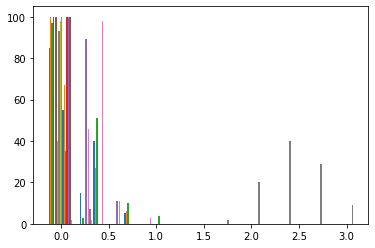

In [35]:
plt.hist([r for r in all_walls_div_array[index,:,:].transpose()/1e9],histtype='bar',align = 'left') 

In [23]:
print('Histograms of damage cost for 100 storms, by division')

print('No wall:')
index = 0
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))
      
bins = np.linspace(0,2.6e9,40)
plt.hist([r for r in all_walls_div_array[index,:,:].transpose()],alpha = 0.6, bins = bins)
plt.ylabel = 'frequency'
plt.xlabel = 'damage cost /$'
plt.title('No Wall')
plt.show()

print('No budget optimal wall:')
index = 164
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))

for i in range(18):
    plt.hist(all_walls_div_array[index,:,i],alpha = 0.6, bins = bins)
plt.show()

print('$1B budget optimal wall:')
budget = 1e9
satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
bmindex = np.argmin(satisfy[:,3])
satisfy_div = all_walls_div_array[all_walls_array[:,4]<=budget,:,:]

print('damage cost ' + str((satisfy[index,3]-satisfy[index,4])/1e9))
print('total cost  ' + str(satisfy[index,3]/1e9))
print('wall cost   ' + str(satisfy[index,4]/1e9))

for i in range(18):
    plt.hist(satisfy_div[bmindex,:,i],alpha = 0.6, bins = bins)
plt.show()

# print('8 part different heights optimal wall:')
# testwall = np.array([2.16666667,1.33333333,2.16666667,0.16666667,0.83333333,1.0,2.0,1.16666667])
# print(testwall)

# print('damage cost ' + str((2320020819.6121426-985060200.7053719)/1e9))
# print('total cost  ' + str(2320020819.6121426/1e9))
# print('wall cost   ' + str(985060200.7053719/1e9))

# wall8_div_array = np.load('wall8partsdivarray.npy')
# for i in range(18):
#     plt.hist(wall8_div_array[:,i],alpha = 0.6, bins = bins)
# plt.show()





Histograms of damage cost for 100 storms, by division
No wall:
damage cost 5.853187676374288
total cost  5.853187676374288
wall cost   0.0


KeyboardInterrupt: 

In [88]:
plt.xlabel

'damage cost /$B'

Histograms of damage cost for 100 storms, by division
No wall:
damage cost 5.853187676374288
total cost  5.853187676374288
wall cost   0.0


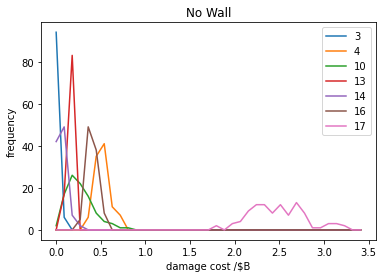

No budget optimal wall:
damage cost 0.45419682232838915
total cost  2.4472828223283893
wall cost   1.993086


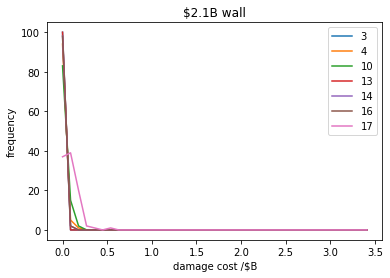

$1B budget optimal wall:
damage cost 2.849098906505345
total cost  3.8431813065053455
wall cost   0.9940824


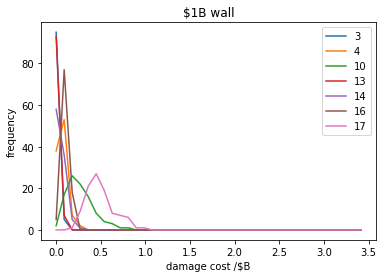

VAR
damage cost 2.9715139546949505
total cost  3.867172354694951
wall cost   0.8956584


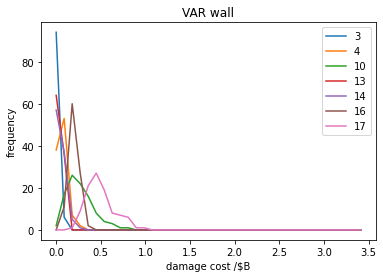

In [102]:
print('Histograms of damage cost for 100 storms, by division')
#divs = [0,3,7,10,17]
divs = [3,4,10,13,14,16,17]
#divs = range(18)
bins = np.linspace(0,3.5,40)


print('No wall:')
index = 0
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))
fig, ax = plt.subplots()
for i in divs:
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c, label = i)
ax.set_ylabel('frequency')
ax.set_xlabel('damage cost /$B')
plt.title('No Wall')
plt.legend()
plt.show()

print('No budget optimal wall:')
index = 164
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))
fig, ax = plt.subplots()
for i in divs:
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c, label = i)
ax.set_ylabel('frequency')
ax.set_xlabel('damage cost /$B')
plt.title('$2.1B wall')
plt.legend()
plt.show()

print('$1B budget optimal wall:')
budget = 1e9
satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
bmindex = np.argmin(satisfy[:,3])
satisfy_div = all_walls_div_array[all_walls_array[:,4]<=budget,:,:]
print('damage cost ' + str((satisfy[bmindex,3]-satisfy[bmindex,4])/1e9))
print('total cost  ' + str(satisfy[bmindex,3]/1e9))
print('wall cost   ' + str(satisfy[bmindex,4]/1e9))
fig, ax = plt.subplots()
for i in divs:
    c, b= np.histogram(satisfy_div[bmindex,:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c, label = i)
ax.set_ylabel('frequency')
ax.set_xlabel('damage cost /$B')
plt.title('$1B wall')
plt.legend()
plt.show()

print('VAR')
index = 93
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))
fig, ax = plt.subplots()
for i in divs:
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c, label = i)
ax.set_ylabel('frequency')
ax.set_xlabel('damage cost /$B')
plt.title('VAR wall')
plt.legend()
plt.show()

# print('$2B budget optimal wall:')
# budget = 2e9
# satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
# bmindex = np.argmin(satisfy[:,3])
# satisfy_div = all_walls_div_array[all_walls_array[:,4]<=budget,:,:]

# print('damage cost ' + str((satisfy[bmindex,3]-satisfy[bmindex,4])/1e9))
# print('total cost  ' + str(satisfy[bmindex,3]/1e9))
# print('wall cost   ' + str(satisfy[bmindex,4]/1e9))

# for i in range(18):
#     c, b= np.histogram(all_walls_div_array[index,:,i], bins = bins)
#     plt.plot(b[:-1],c)
# plt.show()

# print('8 part different heights optimal wall:')
# testwall = np.array([2.16666667,1.33333333,2.16666667,0.16666667,0.83333333,1.0,2.0,1.16666667])
# print(testwall)

# print('damage cost ' + str((2320020819.6121426-985060200.7053719)/1e9))
# print('total cost  ' + str(2320020819.6121426/1e9))
# print('wall cost   ' + str(985060200.7053719/1e9))

# wall8_div_array = np.load('wall8partsdivarray.npy')
# for i in range(18):
#     c, b= np.histogram(all_walls_div_array[index,:,i], bins = bins)
#     plt.plot(b[:-1],c)
# plt.show()




8 part
damage cost 0.5369151766220951
total cost  2.7807428649198798
wall cost   2.243827688297785


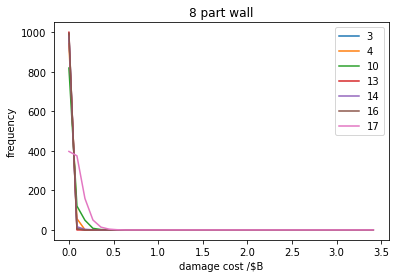

8 part 2
damage cost 0.4833671499272537
total cost  2.4206939351082366
wall cost   1.937326785180983


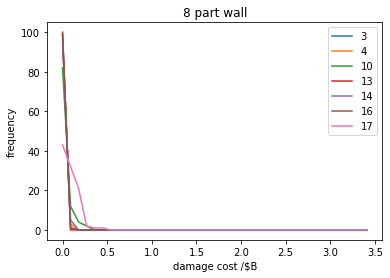

In [107]:
print('8 part')
index = 93
print('damage cost ' + str((bo_total_cost_new-bo_wall_cost)/1e9))
print('total cost  ' + str(bo_total_cost_new/1e9))
print('wall cost   ' + str(bo_wall_cost/1e9))
fig, ax = plt.subplots()
for i in divs:
    c, b= np.histogram(np.array(bo_n_cost_direct_sum_div)[:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c, label = i)
ax.set_ylabel('frequency')
ax.set_xlabel('damage cost /$B')
plt.title('8 part wall')
plt.legend()
plt.show()

print('8 part 2')
index = 93
print('damage cost ' + str((bo2_total_cost_new-bo2_wall_cost)/1e9))
print('total cost  ' + str(bo2_total_cost_new/1e9))
print('wall cost   ' + str(bo2_wall_cost/1e9))
fig, ax = plt.subplots()
for i in divs:
    c, b= np.histogram(np.array(bo2_n_cost_direct_sum_div)[:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c, label = i)
ax.set_ylabel('frequency')
ax.set_xlabel('damage cost /$B')
plt.title('8 part wall')
plt.legend()
plt.show()

In [97]:
np.array(bo_n_cost_direct_sum_div).shape

(100, 18, 1)

In [104]:
bayes_opt_x = [2.7160262125766583, 4.351269630126634, 2.430595104037087, 4.475245157642087, 3.8586888184293002, 1.7553144727634398, 3.0366120648503663, 1.2653153592833672]
bo_total_cost_new, bo_wall_cost, bo_n_cost_direct_sum_div = objective4(bayes_opt_x,num_iter = 1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [106]:
bayes_opt_x2 = [2.4042126739702208, 2.3565100228175635, 4.501075010528714, 3.3812992539903304, 1.8427614401051529, 1.6652348878584669, 0.0, 1.6236098360177833]
bo2_total_cost_new, bo2_wall_cost, bo2_n_cost_direct_sum_div = objective4(bayes_opt_x2,num_iter = 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2420693935.108237


In [82]:
VAR_bools = (np.sum(np.sum((all_walls_div_array[:,:,:] <= 0.5e9), axis = 1) >= 95, axis = 1) == 18)
all_walls_array[VAR_bools][np.argmin(all_walls_array[VAR_bools,4])]

array([0.00000000e+00, 1.63000000e+02, 2.50000000e+00, 2.44728282e+09,
       1.99308600e+09])

In [83]:
for i, b in enumerate(VAR_bools):
    if b:
        print(i)
        break

164


Histograms of damage cost for 100 storms, by division
No wall:
damage cost 5.853187676374288
total cost  5.853187676374288
wall cost   0.0
No budget optimal wall:
damage cost 0.45419682232838915
total cost  2.4472828223283893
wall cost   1.993086
$1B budget optimal wall:
damage cost 5.809926745539627
total cost  6.683439745539627
wall cost   0.873513
8 part different heights optimal wall:
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
damage cost 1.3349606189067706
total cost  2.3200208196121426
wall cost   0.9850602007053718


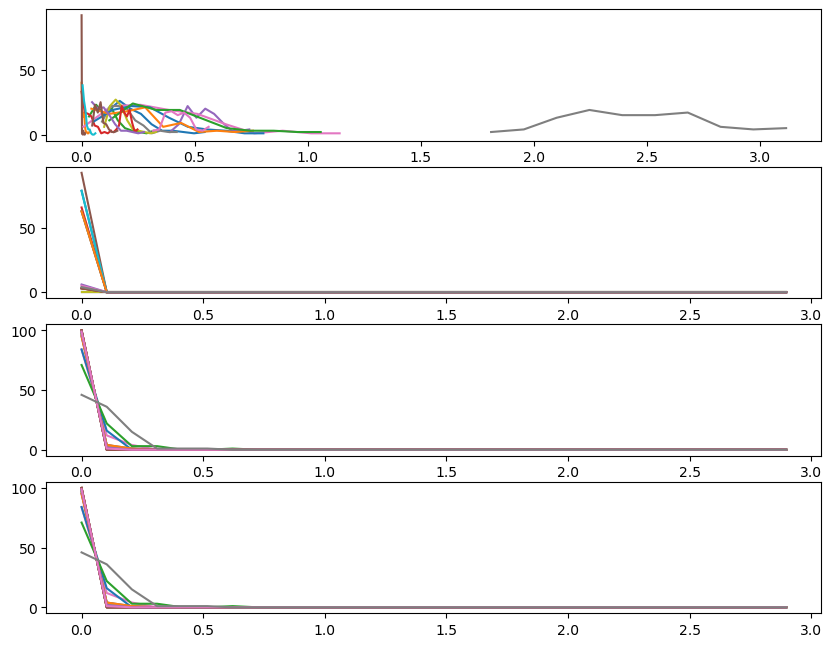

In [34]:
print('Histograms of damage cost for 100 storms, by division')
plt.figure(figsize=(10, 8), dpi=100)
plt.subplot(4,1,1)
print('No wall:')
index = 0
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))
     

bins = np.linspace(0,3,30)
for i in range(18):
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    #c, b= np.histogram(all_walls_div_array[index,:,i]/1e9)
    plt.plot(b[:-1],c)
plt.ylabel = 'frequency'
plt.xlabel = 'damage cost /$'
#plt.title('No Wall')

plt.subplot(4,1,2)
print('No budget optimal wall:')
index = 164
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))

for i in range(18):
    #c, b= np.histogram(all_walls_div_array[index,:,i], bins = bins)
    plt.plot(b[:-1],c)

plt.subplot(4,1,3)
print('$1B budget optimal wall:')
budget = 1e9
satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
bmindex = np.argmin(satisfy[:,3])
satisfy_div = all_walls_div_array[all_walls_array[:,4]<=budget,:,:]

print('damage cost ' + str((satisfy[index,3]-satisfy[index,4])/1e9))
print('total cost  ' + str(satisfy[index,3]/1e9))
print('wall cost   ' + str(satisfy[index,4]/1e9))

for i in range(18):
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c)

plt.subplot(4,1,4)
print('8 part different heights optimal wall:')
testwall = np.array([2.16666667,1.33333333,2.16666667,0.16666667,0.83333333,1.0,2.0,1.16666667])
print(testwall)

print('damage cost ' + str((2320020819.6121426-985060200.7053719)/1e9))
print('total cost  ' + str(2320020819.6121426/1e9))
print('wall cost   ' + str(985060200.7053719/1e9))

#update this with the calculation of the varied wall
wall8_div_array = np.load('wall8partsdivarray.npy')
for i in range(18):
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c)






Histograms of damage cost for 100 storms, by division
No wall:
damage cost 5.853187676374288
total cost  5.853187676374288
wall cost   0.0
No budget optimal wall:
damage cost 0.45419682232838915
total cost  2.4472828223283893
wall cost   1.993086
$1B budget optimal wall:
damage cost 2.849098906505345
total cost  3.8431813065053455
wall cost   0.9940824
8 part different heights optimal wall:
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
damage cost 1.3349606189067706
total cost  2.3200208196121426
wall cost   0.9850602007053718


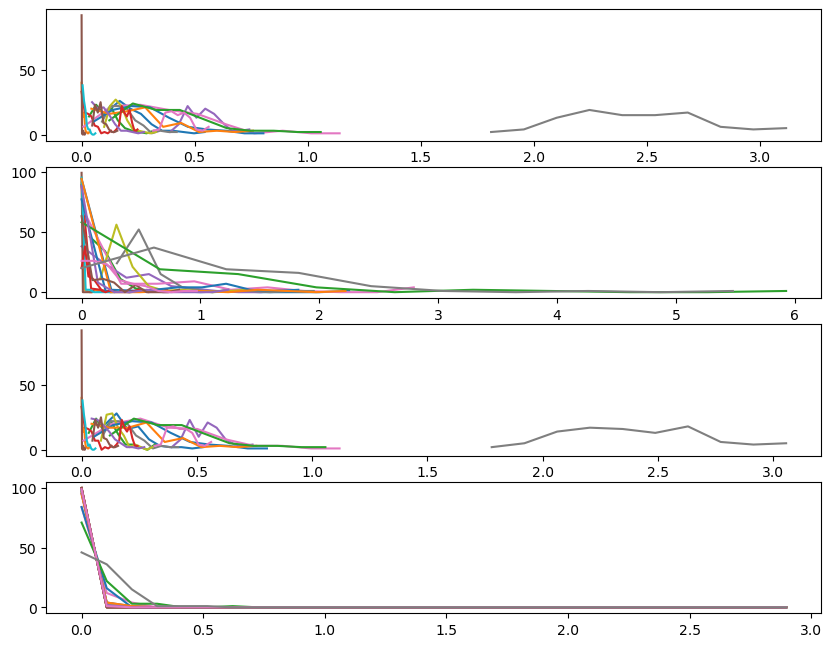

In [37]:
print('Histograms of damage cost for 100 storms, by division')
plt.figure(figsize=(10, 8), dpi=100)
plt.subplot(4,1,1)
print('No wall:')
index = 0
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))
     

#bins = np.linspace(0,3,30)
for i in range(18):
    #c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9)
    plt.plot(b[:-1],c)
plt.ylabel = 'frequency'
plt.xlabel = 'damage cost /$'
#plt.title('No Wall')

plt.subplot(4,1,2)
print('No budget optimal wall:')
index = 164
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))

for i in range(18):
    #c, b= np.histogram(all_walls_div_array[index,:,i], bins = bins)
    c, b = np.histogram(all_walls_div_array[index,:,i])
    plt.plot(b[:-1],c)

plt.subplot(4,1,3)
print('$1B budget optimal wall:')
budget = 1e9
satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
bmindex = np.argmin(satisfy[:,3])
satisfy_div = all_walls_div_array[all_walls_array[:,4]<=budget,:,:]

print('damage cost ' + str((satisfy[bmindex,3]-satisfy[bmindex,4])/1e9))
print('total cost  ' + str(satisfy[bmindex,3]/1e9))
print('wall cost   ' + str(satisfy[bmindex,4]/1e9))

for i in range(18):
    #c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    c, b = np.histogram(all_walls_div_array[bmindex,:,i])
    plt.plot(b[:-1],c)

plt.subplot(4,1,4)
print('8 part different heights optimal wall:')
testwall = np.array([2.16666667,1.33333333,2.16666667,0.16666667,0.83333333,1.0,2.0,1.16666667])
print(testwall)

print('damage cost ' + str((2320020819.6121426-985060200.7053719)/1e9))
print('total cost  ' + str(2320020819.6121426/1e9))
print('wall cost   ' + str(985060200.7053719/1e9))

#update this with the calculation of the varied wall
wall8_div_array = np.load('wall8partsdivarray.npy')
for i in range(18):
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c)






In [15]:
len(all_walls_div_array[0,:,0])

100

In [22]:
len(all_walls_array)

1520

Histograms of damage cost for 100 storms, by division
No wall:
damage cost 5.853187676374288
total cost  5.853187676374288
wall cost   0.0
No budget optimal wall:
damage cost 0.45419682232838915
total cost  2.4472828223283893
wall cost   1.993086
$1B budget optimal wall:
damage cost 5.809926745539627
total cost  6.683439745539627
wall cost   0.873513
8 part different heights optimal wall:
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
damage cost 1.3349606189067706
total cost  2.3200208196121426
wall cost   0.9850602007053718


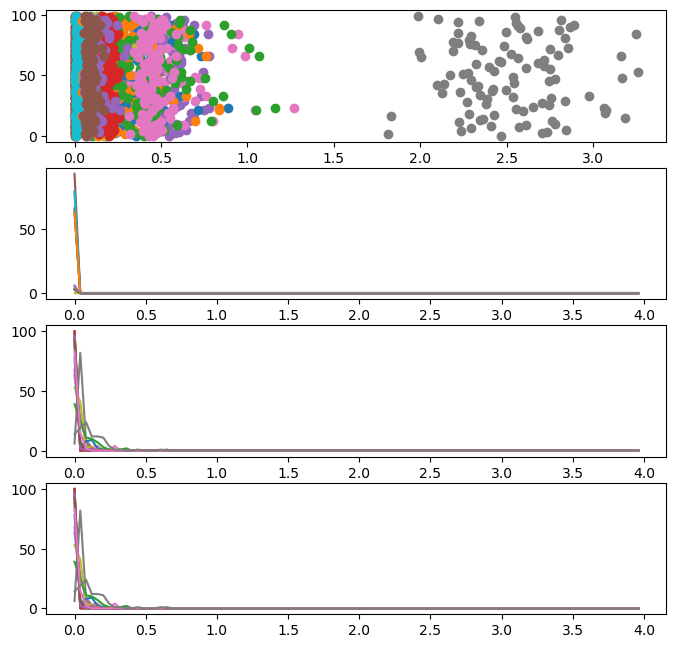

In [17]:
print('Histograms of damage cost for 100 storms, by division')
plt.figure(figsize=(8, 8), dpi=100)
plt.subplot(4,1,1)
print('No wall:')
index = 0
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))
     

bins = np.linspace(0,4,100)
for i in range(18):
    plt.scatter(all_walls_div_array[index,:,i]/1e9,range(100))
plt.ylabel = 'frequency'
plt.xlabel = 'damage cost /$'
#plt.title('No Wall')

plt.subplot(4,1,2)
print('No budget optimal wall:')
index = 164
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))

for i in range(18):
    c, b= np.histogram(all_walls_div_array[index,:,i], bins = bins)
    plt.plot(b[:-1],c)

plt.subplot(4,1,3)
print('$1B budget optimal wall:')
budget = 1e9
satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
bmindex = np.argmin(satisfy[:,3])
satisfy_div = all_walls_div_array[all_walls_array[:,4]<=budget,:,:]

print('damage cost ' + str((satisfy[index,3]-satisfy[index,4])/1e9))
print('total cost  ' + str(satisfy[index,3]/1e9))
print('wall cost   ' + str(satisfy[index,4]/1e9))

for i in range(18):
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c)

plt.subplot(4,1,4)
print('8 part different heights optimal wall:')
testwall = np.array([2.16666667,1.33333333,2.16666667,0.16666667,0.83333333,1.0,2.0,1.16666667])
print(testwall)

print('damage cost ' + str((2320020819.6121426-985060200.7053719)/1e9))
print('total cost  ' + str(2320020819.6121426/1e9))
print('wall cost   ' + str(985060200.7053719/1e9))

#update this with the calculation of the varied wall
wall8_div_array = np.load('wall8partsdivarray.npy')
for i in range(18):
    c, b= np.histogram(all_walls_div_array[index,:,i]/1e9, bins = bins)
    plt.plot(b[:-1],c)






TypeError: 'str' object is not callable

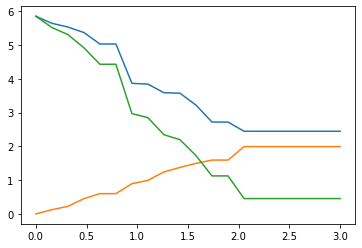

In [11]:
total_cost_list = []
wall_cost_list = []
damage_cost_list = []
budgets = np.linspace(0,3e9,20)
for budget in budgets:
    satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
    bmindex = np.argmin(satisfy[:,3])
    total_cost_list.append(satisfy[bmindex,3]/1e9)
    wall_cost_list.append(satisfy[bmindex,4]/1e9)
    damage_cost_list.append(satisfy[bmindex,3]/1e9-satisfy[bmindex,4]/1e9)
    
plt.plot(budgets/1e9,total_cost_list, label = 'total cost')
plt.plot(budgets/1e9,wall_cost_list, label = 'wall cost')
plt.plot(budgets/1e9,damage_cost_list, label = 'damage cost')
plt.ylabel('cost / $billion')
plt.xlabel('budget /$billion')
plt.legend()
plt.show()

In [52]:
B = 5e8
if np.sum(np.sum(all_walls_div_array[164,:,:] < B, axis = 0) > 95) == 18:
    print('satisfy')
print(np.sum(all_walls_div_array[164,:,:] < B, axis = 0) > 95)

satisfy
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [53]:
print(all_walls_array[164,3])

2447282822.328389


In [ ]:
for i in range(15)

ideas and to-dos
input geoclaw data into GISSR. see if we can vary location around wall as boundary condition. not single height
sensitivity to input storms

notions of fairness:
area 17 or whatever it is gets inundated super easily. to do with topography? you can check this. 
it requires higher wall. is this fair?
consider not just economic cost but social factors as constraint




### make surge data from geoclaw runs:

In [9]:
num_files = 130
num_gauges = 10

In [10]:
outputs = []
for i in range(num_files):
    print(i)
    gauge_data = []
    for j in range(num_gauges):
        address = '../../../nyc-storm-surge-dataset/outputs/'+format(i,'04d')+'_output/gauge'+format(j+1,'05d')+'.txt'
        gauge_data.append(np.loadtxt(address,skiprows =3))
    outputs.append(gauge_data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129


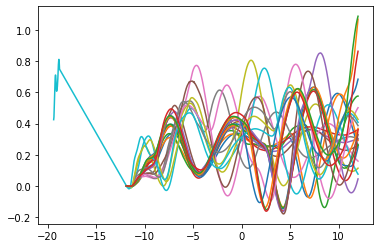

In [13]:
for i in range(24):
    g1 = outputs[i][0]
    plt.plot(g1[g1[:,0]==5,1]/3600,g1[g1[:,0]==5,5])

43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43191.95
43187.93
43187.93


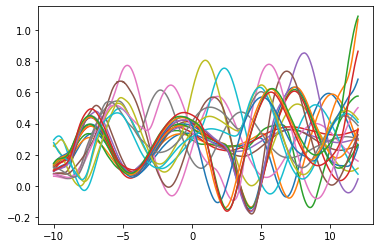

In [34]:
SurgeDataGeo = []
timing_matrix = []
for i in range(24):
    g1 = outputs[i][0]
    show = g1[:,1]>-36000
    SurgeDataGeo.append(np.interp(times, g1[show,1]/3600, g1[show,5]))
    plt.plot(g1[show,1]/3600,g1[show,5])
    print(g1[-1,1])
    timing_matrix.append(times)

In [19]:
times = np.linspace(-10,12,20)

In [18]:
43191/3600

11.9975

In [35]:
SurgeDataGeo = np.array(SurgeDataGeo)
timing_matrix = np.array(timing_matrix)

In [38]:
print(SurgeDataGeo.shape)
print(timing_matrix)

(24, 20)
[[-10.          -8.84210526  -7.68421053  -6.52631579  -5.36842105
   -4.21052632  -3.05263158  -1.89473684  -0.73684211   0.42105263
    1.57894737   2.73684211   3.89473684   5.05263158   6.21052632
    7.36842105   8.52631579   9.68421053  10.84210526  12.        ]
 [-10.          -8.84210526  -7.68421053  -6.52631579  -5.36842105
   -4.21052632  -3.05263158  -1.89473684  -0.73684211   0.42105263
    1.57894737   2.73684211   3.89473684   5.05263158   6.21052632
    7.36842105   8.52631579   9.68421053  10.84210526  12.        ]
 [-10.          -8.84210526  -7.68421053  -6.52631579  -5.36842105
   -4.21052632  -3.05263158  -1.89473684  -0.73684211   0.42105263
    1.57894737   2.73684211   3.89473684   5.05263158   6.21052632
    7.36842105   8.52631579   9.68421053  10.84210526  12.        ]
 [-10.          -8.84210526  -7.68421053  -6.52631579  -5.36842105
   -4.21052632  -3.05263158  -1.89473684  -0.73684211   0.42105263
    1.57894737   2.73684211   3.89473684   5.05263

In [32]:
peak = np.max(SurgeDataGeo,axis = 1)
peak = peak.reshape(-1,1)

In [33]:
print(peak)

[[0.59010308]
 [0.56409741]
 [0.5768437 ]
 [0.37855894]
 [0.42006248]
 [0.48443859]
 [0.7163195 ]
 [0.58895213]
 [0.73758417]
 [0.71773134]
 [0.63371111]
 [0.632597  ]
 [0.6181966 ]
 [0.60860734]
 [0.80318852]
 [0.68683371]
 [0.72699495]
 [0.60437037]
 [0.64803856]
 [0.62846972]
 [0.6853476 ]
 [1.069873  ]
 [1.08944   ]
 [0.8644782 ]]


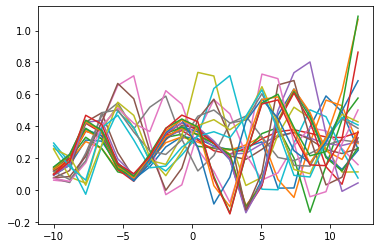

In [40]:
for i in range(24):
    plt.plot(timing_matrix[i,:],SurgeDataGeo[i,:])

In [43]:
np.save('SurgeDataGeo/0-peak_w.npy',peak)
np.save('SurgeDataGeo/0-waterlevel_w.npy',SurgeDataGeo)
np.save('SurgeDataGeo/0-time_w.npy',timing_matrix)

In [23]:
objective2([3.2687253766155515,
 1.8039208442832713,
 2.9035802422449515,
 1.6200833446016525,
 1.4627162361677573,
 1.3080887633766016,
 5.0,
 1.0524189281894356])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2175538199.330912


2175538199.330912

In [24]:
h_bayesopt = [3.2687253766155515,
 1.8039208442832713,
 2.9035802422449515,
 1.6200833446016525,
 1.4627162361677573,
 1.3080887633766016,
 5.0,
 1.0524189281894356]

In [27]:
total_cost_new, wall_cost, n_cost_direct_sum_div = objective4(h_bayesopt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2175538199.330912


In [28]:
print(total_cost_new, wall_cost, n_cost_direct_sum_div)

2175538199.330912 1465089008.9156032 [array([[ 8481258.56688152],
       [  140633.010348  ],
       [ 2897318.66979856],
       [ 3406355.66367424],
       [ 3108611.90116118],
       [   76850.88269933],
       [  904127.20362826],
       [15060323.33354038],
       [ 2550694.44645151],
       [  233577.15043448],
       [63630360.76907831],
       [10131575.27431696],
       [70623345.65296574],
       [ 1975114.25056294],
       [  466700.25523423],
       [  617172.90433384],
       [ 3675556.53493353],
       [20103295.06856112]]), array([[4.40266724e+06],
       [9.70201429e+05],
       [2.25957527e+07],
       [5.03165456e+06],
       [8.44549646e+06],
       [2.58032908e+03],
       [9.50502518e+07],
       [1.65134928e+07],
       [6.43936487e+06],
       [1.85323878e+05],
       [9.20298201e+04],
       [6.76979003e+06],
       [4.64562854e+07],
       [4.15566108e+06],
       [1.09656309e+06],
       [1.35898475e+06],
       [7.29255146e+06],
       [5.00288246e+07]]), arra

# f(h_wall)

In [3]:
print(all_walls_array.shape)
print('start, end, height, total cost, wall cost')
print(all_walls_div_array.shape)

(1520, 5)
start, end, height, total cost, wall cost
(1520, 100, 18)


In [10]:
comp_wall_list = []
for wall_array in all_walls_array:
    if np.array_equal(wall_array[:2],[0.0,163.0]):
        comp_wall_list.append(wall_array)
comp_wall_array = np.array(comp_wall_list)

In [15]:
print(comp_wall_array)

[[0.00000000e+00 1.63000000e+02 5.00000000e-01 5.55256936e+09
  3.98617200e+08]
 [0.00000000e+00 1.63000000e+02 1.00000000e+00 5.44798583e+09
  7.97234400e+08]
 [0.00000000e+00 1.63000000e+02 1.50000000e+00 4.69803287e+09
  1.19585160e+09]
 [0.00000000e+00 1.63000000e+02 2.00000000e+00 2.71983924e+09
  1.59446880e+09]
 [0.00000000e+00 1.63000000e+02 2.50000000e+00 2.44728282e+09
  1.99308600e+09]
 [0.00000000e+00 1.63000000e+02 3.00000000e+00 2.69866116e+09
  2.39170320e+09]
 [0.00000000e+00 1.63000000e+02 3.50000000e+00 3.01511551e+09
  2.79032040e+09]
 [0.00000000e+00 1.63000000e+02 4.00000000e+00 3.37880044e+09
  3.18893760e+09]
 [0.00000000e+00 1.63000000e+02 4.50000000e+00 3.77083628e+09
  3.58755480e+09]
 [0.00000000e+00 1.63000000e+02 5.00000000e+00 4.16148231e+09
  3.98617200e+09]]


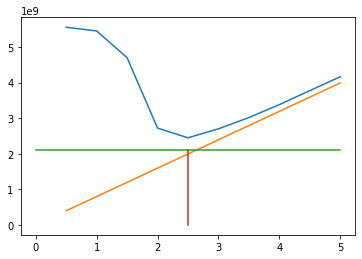

In [14]:
plt.plot(comp_wall_array[:,2],comp_wall_array[:,3])
plt.plot(comp_wall_array[:,2],comp_wall_array[:,4])
plt.plot([0,5],[2.1e9,2.1e9])
plt.plot([2.5,2.5],[0,2.1e9])

In [17]:
hundred_sets_sums = np.sum(all_walls_div_array, axis = 2)

0

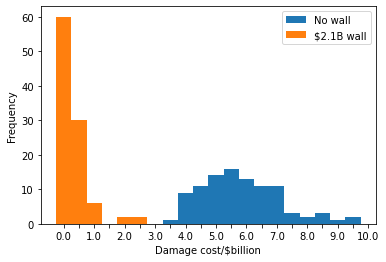

In [54]:
plt.hist(hundred_sets_sums[0]/1e9, bins = np.linspace(0,10,21), align = 'left', label = 'No wall')
plt.xticks(ticks = np.linspace(0,10,21),labels = [i if i == int(i) else None for i in np.linspace(0,10,21)])
plt.hist(hundred_sets_sums[164]/1e9, bins = np.linspace(0,10,21), align = 'left', label = '$2.1B wall')
plt.xlabel('Damage cost/$billion')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("DamageHistogram.svg")
0

164


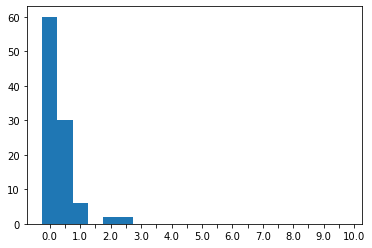

In [50]:
for i, wall_array in enumerate(all_walls_array):
    if np.array_equal(wall_array[:3],[0.0,163.0, 2.5]):
        print(i)
        plt.hist(hundred_sets_sums[i]/1e9, bins = np.linspace(0,10,21), align = 'left')
        plt.xticks(ticks = np.linspace(0,10,21),labels = [i if i == int(i) else None for i in np.linspace(0,10,21)])
        



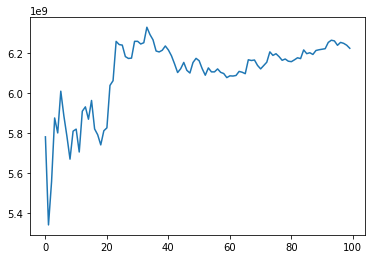

In [57]:
running_mean = []
for i in range(100):
    running_mean.append(np.mean(hundred_sets_sums[0,:(i+1)]))
plt.plot(running_mean)

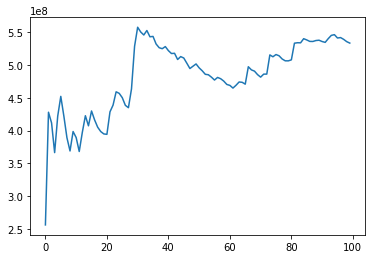

In [58]:
running_mean = []
for i in range(100):
    running_mean.append(np.mean(hundred_sets_sums[164,:(i+1)]))
plt.plot(running_mean)

In [ ]:
plt.plot(running_mean)

In [60]:
NW_total_cost_new, NW_wall_cost, NW_n_cost_direct_sum_div =  objective3((0,0,0), numiter = 1000)

(0, 0, 0)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


In [76]:
#NW_n_cost_direct_sum_div  = np.array(NW_n_cost_direct_sum_div)
#np.save("NW_n_cost_direct_sum_div",NW_n_cost_direct_sum_div)

In [3]:
NW_n_cost_direct_sum_div  = np.load("NW_n_cost_direct_sum_div.npy")

In [4]:
NW_n_cost_direct_sum_div.shape

(1000, 18, 1)

In [5]:
NW_set_sums = np.sum(NW_n_cost_direct_sum_div, axis = 1)
#NW_set_sums = np.sum(NW_set_sums, axis = 1)
NW_set_sums.shape

(1000, 1)

In [10]:
print(np.mean(NW_set_sums)/1e9)
print(np.std(NW_set_sums)/1e9)

6.173134670892678
1.4684029453736125


C:\Users\pdine\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pdine\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


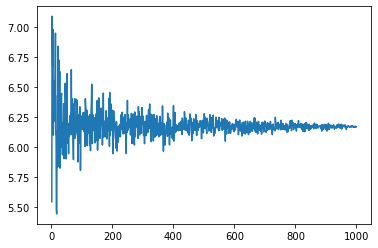

In [6]:
running_mean = []
for i in range(1000):
    running_mean.append(np.mean(NW_set_sums[np.random.permutation(1000)][:i]/1e9))
plt.plot(running_mean)

In [62]:
TB_total_cost_new, TB_wall_cost, TB_n_cost_direct_sum_div =  objective3((0,163,2.5), numiter = 1000)

(0, 163, 2.5)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273


In [77]:
#TB_n_cost_direct_sum_div  = np.array(TB_n_cost_direct_sum_div)
#np.save("TB_n_cost_direct_sum_div",TB_n_cost_direct_sum_div)

In [11]:
TB_n_cost_direct_sum_div = np.load("TB_n_cost_direct_sum_div.npy")

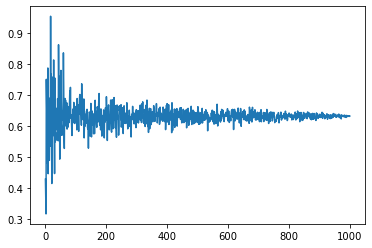

In [12]:
TB_set_sums = np.sum(TB_n_cost_direct_sum_div, axis = 1)
#NW_set_sums = np.sum(NW_set_sums, axis = 1)
TB_set_sums.shape
running_mean_TB = []
for i in range(1000):
    running_mean_TB.append(np.mean(TB_set_sums[np.random.permutation(1000)][:i]/1e9))
plt.plot(running_mean_TB)

In [13]:
print(np.mean(TB_set_sums)/1e9)
print(np.std(TB_set_sums)/1e9)

0.6321156884718703
0.5264217880425214


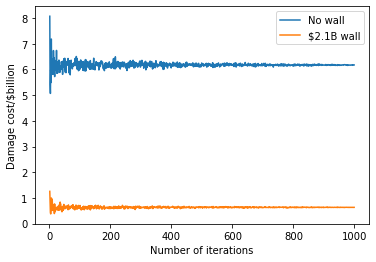

In [104]:
plt.plot(running_mean,label = 'No wall')
plt.plot(running_mean_TB, label = '$2.1B wall')
plt.xlabel('Number of iterations')
plt.ylabel('Damage cost/$billion')
plt.legend()
plt.savefig("damagecostconvergence.svg")

0

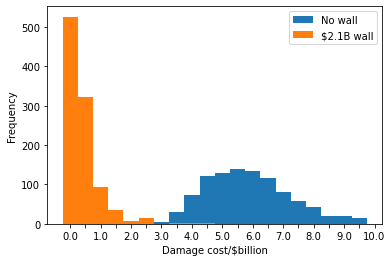

In [107]:
plt.hist(NW_set_sums[:,0]/1e9, bins = np.linspace(0,10,21), align = 'left', label = 'No wall')
plt.hist(TB_set_sums[:,0]/1e9, bins = np.linspace(0,10,21), align = 'left', label = '$2.1B wall')
plt.xticks(ticks = np.linspace(0,10,21),labels = [i if i == int(i) else None for i in np.linspace(0,10,21)])
plt.xlabel('Damage cost/$billion')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("DamageHistogram.svg")
0

0

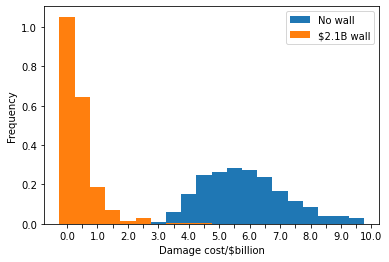

In [106]:
plt.hist(NW_set_sums[:,0]/1e9, bins = np.linspace(0,10,21), align = 'left', label = 'No wall', density = True)
plt.hist(TB_set_sums[:,0]/1e9, bins = np.linspace(0,10,21), align = 'left', label = '$2.1B wall', density = True)
plt.xticks(ticks = np.linspace(0,10,21),labels = [i if i == int(i) else None for i in np.linspace(0,10,21)])
plt.xlabel('Damage cost/$billion')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("DamageHistogramDensity.svg")
0

In [108]:
TBtest_total_cost_new, TBtest_wall_cost, TBtest_n_cost_direct_sum_div =  objective3_test((0,163,2.5), numiter = 5)

(0, 163, 2.5)
0
1
2
3
4


In [75]:
TB_n_cost_direct_sum_div = np.array(TB_n_cost_direct_sum_div)
TBtest_n_cost_direct_sum_div = np.array(TBtest_n_cost_direct_sum_div)
TB_n_cost_direct_sum_div[:5,:] - TBtest_n_cost_direct_sum_div[:5,:]

array([[[0.00000000e+00],
        [0.00000000e+00],
        [2.07658179e+07],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [4.29141374e+07],
        [8.16968428e+07],
        [5.48344913e+07],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[0.00000000e+00],
        [0.00000000e+00],
        [3.54445448e+07],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [1.93027827e+08],
        [6.25689500e+07],
        [4.17206674e+07],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[0.00000000e+00],
        [0.00000000e+00],
        